In [1]:
# 환경 설정
import os
import random
import pickle
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from tqdm import tqdm
import pandas as pd

# GPU 설정
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = os.getenv('MIL_STAGE3_GPU', '3')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('CUDA를 사용할 수 없습니다. CPU 모드로 실행됩니다.')

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f'🔒 모든 시드를 {seed}로 고정완료')

seed_everything(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 3090
🔒 모든 시드를 42로 고정완료


In [2]:
# Stage 3: 위조 비율별 5개 MIL 모델 학습/평가 + FCR/IER 메타데이터 분석
# L=20 기준 데이터로 5개 MIL 모델(Attention/Gated/DSMIL/Mean/Transformer) 비교 실험
# FCR(문서 현실 위조비율) vs IER(모델 체감 위조비율) 심화 분석 포함

import os
import random
import pickle
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, RandomSampler
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score
from tqdm import tqdm
import pandas as pd

# GPU 설정
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = os.getenv('MIL_STAGE3_GPU', '3')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
if device.type == 'cuda':
    print('GPU:', torch.cuda.get_device_name(0))
else:
    print('CUDA를 사용할 수 없습니다. CPU 모드로 실행됩니다.')

def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f'🔒 모든 시드를 {seed}로 고정완료')

seed_everything(42)

Using device: cuda
GPU: NVIDIA GeForce RTX 3090
🔒 모든 시드를 42로 고정완료


In [3]:
# 위조 비율별 데이터 로드 유틸리티
def ratio_to_tag(pos_ratio: float) -> str:
    return f'{int(round(pos_ratio*100)):02d}p'

def to_instance_means(bags):
    # (10,5,256) -> (10,256) 평균화
    return [bag.mean(axis=1).astype(np.float32) for bag in bags]

def load_forgery_data(bags_dir, margin='0.4', ratios=[0.05,0.10,0.20,0.30,0.50]):
    data = {}
    print('📁 위조 비율별 데이터 로딩 중...')
    print('='*60)
    for ratio in ratios:
        rtag = ratio_to_tag(ratio)
        print(f'  Loading {rtag} ({ratio:.0%}) datasets...')
        train_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_train.pkl')
        val_pkl   = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_val.pkl')
        test_pkl  = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_test.pkl')
        try:
            with open(train_pkl,'rb') as f: train_data = pickle.load(f)
            with open(val_pkl,'rb')   as f: val_data   = pickle.load(f)
            with open(test_pkl,'rb')  as f: test_data  = pickle.load(f)
            data[rtag] = {
                'train': train_data,
                'val': val_data,
                'test': test_data,
                'ratio': ratio
            }
            print(f'    ✅ {rtag}: Train={len(train_data["labels"])}, Val={len(val_data["labels"])}, Test={len(test_data["labels"])})')
        except FileNotFoundError as e:
            print(f'    ❌ {rtag}: 파일 없음 - {e}')
    print('='*60)
    print(f'✅ 총 {len(data)}개 비율 데이터셋 로드 완료')
    return data

def load_shift_data(bags_dir, margin='0.4', train_ratio=0.30, eval_ratios=[0.05,0.10,0.20,0.30,0.50]):
    print('📁 Shift 모드 데이터 로딩 중...')
    print('='*60)
    rtag_train = ratio_to_tag(train_ratio)
    train_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag_train}_random_train.pkl')
    val_pkl   = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag_train}_random_val.pkl')
    train_pkl_shift = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag_train}_random_train_shiftbase.pkl')
    val_pkl_shift   = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag_train}_random_val_shiftbase.pkl')
    if os.path.exists(train_pkl_shift): train_pkl = train_pkl_shift
    if os.path.exists(val_pkl_shift):   val_pkl   = val_pkl_shift
    with open(train_pkl,'rb') as f: train_data = pickle.load(f)
    with open(val_pkl,'rb')   as f: val_data   = pickle.load(f)
    print(f'  학습용 {rtag_train} ({train_ratio:.0%}): Train={len(train_data["labels"])}, Val={len(val_data["labels"])})')
    eval_sets = {}
    for ratio in eval_ratios:
        rtag = ratio_to_tag(ratio)
        test_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_test_shift_{rtag}.pkl')
        if not os.path.exists(test_pkl):
            test_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_test.pkl')
        try:
            with open(test_pkl,'rb') as f: test_data = pickle.load(f)
            eval_sets[rtag] = {'test': test_data, 'ratio': ratio}
            print(f'  평가용 {rtag} ({ratio:.0%}): Test={len(test_data["labels"])}')
        except FileNotFoundError:
            print(f'  ❌ {rtag}: 평가 파일 없음')
    print('='*60)
    print(f'✅ Shift 모드 데이터 로드 완료: 학습 {rtag_train} + 평가 {len(eval_sets)}개')
    return {'train': train_data, 'val': val_data, 'eval_sets': eval_sets, 'train_ratio': train_ratio}

print('✅ 위조 비율별 데이터 로드 유틸리티 정의 완료')

✅ 위조 비율별 데이터 로드 유틸리티 정의 완료


In [ ]:
# Forgery ratio data loading utility
def ratio_to_tag(pos_ratio: float) -> str:
    return f'{int(round(pos_ratio*100)):02d}p'

def to_instance_means(bags):
    # (10,5,256) -> (10,256) 평균화
    return [bag.mean(axis=1).astype(np.float32) for bag in bags]

def load_forgery_data(bags_dir, margin='0.4', ratios=[0.05,0.10,0.20,0.30,0.50]):
    data = {}
    print('Loading forgery ratio datasets...')
    print('='*60)
    for ratio in ratios:
        rtag = ratio_to_tag(ratio)
        print(f'  Loading {rtag} ({ratio:.0%}) datasets...')
        train_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_train.pkl')
        val_pkl   = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_val.pkl')
        test_pkl  = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_test.pkl')
        try:
            with open(train_pkl,'rb') as f: train_data = pickle.load(f)
            with open(val_pkl,'rb')   as f: val_data   = pickle.load(f)
            with open(test_pkl,'rb')  as f: test_data  = pickle.load(f)
            data[rtag] = {
                'train': train_data,
                'val': val_data,
                'test': test_data,
                'ratio': ratio
            }
            print(f'    ✅ {rtag}: Train={len(train_data["labels"])}, Val={len(val_data["labels"])}, Test={len(test_data["labels"])})')
        except FileNotFoundError as e:
            print(f'    ❌ {rtag}: File not found - {e}')
    print('='*60)
    print(f'✅ Total {len(data)} ratio datasets loaded')
    return data

def load_shift_data(bags_dir, margin='0.4', train_ratio=0.30, eval_ratios=[0.05,0.10,0.20,0.30,0.50]):
    print('Loading Shift mode data...')
    print('='*60)
    rtag_train = ratio_to_tag(train_ratio)
    train_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag_train}_random_train.pkl')
    val_pkl   = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag_train}_random_val.pkl')
    train_pkl_shift = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag_train}_random_train_shiftbase.pkl')
    val_pkl_shift   = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag_train}_random_val_shiftbase.pkl')
    if os.path.exists(train_pkl_shift): train_pkl = train_pkl_shift
    if os.path.exists(val_pkl_shift):   val_pkl   = val_pkl_shift
    with open(train_pkl,'rb') as f: train_data = pickle.load(f)
    with open(val_pkl,'rb')   as f: val_data   = pickle.load(f)
    print(f'  Training {rtag_train} ({train_ratio:.0%}): Train={len(train_data["labels"])}, Val={len(val_data["labels"])})')
    eval_sets = {}
    for ratio in eval_ratios:
        rtag = ratio_to_tag(ratio)
        test_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_test_shift_{rtag}.pkl')
        if not os.path.exists(test_pkl):
            test_pkl = os.path.join(bags_dir, f'bags_arcface_margin_{margin}_{rtag}_random_test.pkl')
        try:
            with open(test_pkl,'rb') as f: test_data = pickle.load(f)
            eval_sets[rtag] = {'test': test_data, 'ratio': ratio}
            print(f'  Evaluation {rtag} ({ratio:.0%}): Test={len(test_data["labels"])}')
        except FileNotFoundError:
            print(f'  ❌ {rtag}: Evaluation file not found')
    print('='*60)
    print(f'✅ Shift mode data loaded: Training {rtag_train} + {len(eval_sets)} evaluation sets')
    return {'train': train_data, 'val': val_data, 'eval_sets': eval_sets, 'train_ratio': train_ratio}

print('✅ Forgery ratio data loading utilities defined')

In [ ]:
# WeightedBCE loss function (same as baseline)
class WeightedBCE(nn.Module):
    """Weighted Binary Cross Entropy Loss - Higher weight for False Positives"""
    def __init__(self, fp_weight=2.0):
        super().__init__()
        self.fp_weight = fp_weight
        self.bce = nn.BCEWithLogitsLoss(reduction='none')
    def forward(self, logits, labels):
        loss = self.bce(logits, labels)
        fp_mask = (labels == 0).float()
        loss = loss * (1 + self.fp_weight * fp_mask)
        return loss.mean()

print('✅ WeightedBCE loss function class defined')

In [ ]:
# Model definitions: Attention / Gated / DSMIL(simplified) / Mean / TransformerMIL
class AttentionMIL(nn.Module):
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1):
        super().__init__()
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        self.drop = nn.Dropout(dropout_p)
        self.att1 = nn.Linear(hidden_dim, hidden_dim)
        self.att2 = nn.Linear(hidden_dim, 1)
        self.cls  = nn.Linear(hidden_dim, 1)
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu'); nn.init.zeros_(self.instance_fc.bias)
        nn.init.xavier_uniform_(self.att1.weight); nn.init.zeros_(self.att1.bias)
        nn.init.xavier_uniform_(self.att2.weight); nn.init.zeros_(self.att2.bias)
        nn.init.xavier_uniform_(self.cls.weight);  nn.init.zeros_(self.cls.bias)
    def forward(self, x):
        h = torch.relu(self.instance_fc(x)); h = self.drop(h)
        a = torch.tanh(self.att1(h)); a = self.att2(a).squeeze(-1)
        w = torch.softmax(a, dim=1)
        z = torch.sum(w.unsqueeze(-1) * h, dim=1); z = self.drop(z)
        return self.cls(z).squeeze(-1), w

class GatedAttentionMIL(nn.Module):
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1):
        super().__init__()
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        self.drop = nn.Dropout(dropout_p)
        self.att1  = nn.Linear(hidden_dim, hidden_dim)
        self.gate1 = nn.Linear(hidden_dim, hidden_dim)
        self.att2  = nn.Linear(hidden_dim, 1)
        self.cls   = nn.Linear(hidden_dim, 1)
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu'); nn.init.zeros_(self.instance_fc.bias)
        nn.init.xavier_uniform_(self.att1.weight);  nn.init.zeros_(self.att1.bias)
        nn.init.xavier_uniform_(self.gate1.weight); nn.init.zeros_(self.gate1.bias)
        nn.init.xavier_uniform_(self.att2.weight);  nn.init.zeros_(self.att2.bias)
        nn.init.xavier_uniform_(self.cls.weight);   nn.init.zeros_(self.cls.bias)
    def forward(self, x):
        h = torch.relu(self.instance_fc(x)); h = self.drop(h)
        a = torch.tanh(self.att1(h)); g = torch.sigmoid(self.gate1(h))
        s = self.att2(a * g).squeeze(-1)
        w = torch.softmax(s, dim=1)
        z = torch.sum(w.unsqueeze(-1) * h, dim=1); z = self.drop(z)
        return self.cls(z).squeeze(-1), w

class DSMILModel(nn.Module):
    """DSMIL (Dual-stream MIL) - baseline structure maintained
    Stream1: Attention-based weighted sum + Stream2: Max-pooling, concat then classify"""
    def __init__(self, input_dim=256, hidden_dim=128, dropout_p=0.1):
        super().__init__()
        # Common Instance-level feature transformation
        self.instance_fc = nn.Linear(input_dim, hidden_dim)
        self.drop = nn.Dropout(dropout_p)
        # Stream 1: Attention-based stream
        self.attention_fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.attention_fc2 = nn.Linear(hidden_dim, 1)
        # Stream 2: Max pooling-based stream
        self.max_pool_fc = nn.Linear(hidden_dim, hidden_dim)
        # Two-stream fusion classifier
        self.classifier = nn.Linear(hidden_dim*2, 1)
        # Initialization (same as baseline)
        nn.init.kaiming_uniform_(self.instance_fc.weight, nonlinearity='relu'); nn.init.zeros_(self.instance_fc.bias)
        nn.init.xavier_uniform_(self.attention_fc1.weight); nn.init.zeros_(self.attention_fc1.bias)
        nn.init.xavier_uniform_(self.attention_fc2.weight); nn.init.zeros_(self.attention_fc2.bias)
        nn.init.xavier_uniform_(self.max_pool_fc.weight); nn.init.zeros_(self.max_pool_fc.bias)
        nn.init.xavier_uniform_(self.classifier.weight);  nn.init.zeros_(self.classifier.bias)
    def forward(self, x):
        # (B, N, input_dim) -> (B, N, hidden_dim)
        h = torch.relu(self.instance_fc(x)); h = self.drop(h)
        # Attention stream
        attention_scores = torch.tanh(self.attention_fc1(h))
        attention_weights = self.attention_fc2(attention_scores)
        attention_weights = torch.softmax(attention_weights.squeeze(-1), dim=1)
        stream1_repr = torch.sum(attention_weights.unsqueeze(-1) * h, dim=1)
        # Max-pool stream
        stream2_features = torch.relu(self.max_pool_fc(h))
        stream2_repr = torch.max(stream2_features, dim=1)[0]
        # concat & classify
        combined_repr = torch.cat([stream1_repr, stream2_repr], dim=1); combined_repr = self.drop(combined_repr)
        logits = self.classifier(combined_repr).squeeze(-1)
        return logits, attention_weights

class MeanPoolingModel(nn.Module):
    def __init__(self, input_dim=256):
        super().__init__()
        self.fc = nn.Linear(input_dim, 1)
        nn.init.xavier_uniform_(self.fc.weight); nn.init.zeros_(self.fc.bias)
    def forward(self, x):
        return self.fc(x.mean(dim=1)).squeeze(-1)

class SinusoidalPositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 512, dropout_p: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)
    def forward(self, x):
        B,N,D = x.size(); return self.dropout(x + self.pe[:N].unsqueeze(0))

class AttentionPooler(nn.Module):
    def __init__(self, d_model: int, hidden: int = 128, dropout_p: float = 0.1):
        super().__init__()
        self.fc1 = nn.Linear(d_model, hidden); self.fc2 = nn.Linear(hidden, 1); self.drop = nn.Dropout(dropout_p)
        nn.init.xavier_uniform_(self.fc1.weight); nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight); nn.init.zeros_(self.fc2.bias)
    def forward(self, H):
        A = torch.tanh(self.fc1(self.drop(H))); A = self.fc2(A).squeeze(-1)
        w = torch.softmax(A, dim=1); Z = torch.sum(w.unsqueeze(-1)*H, dim=1); return Z, w

class TransformerMIL(nn.Module):
    def __init__(self, input_dim=256, d_model=128, nhead=4, num_layers=2, dim_feedforward=256, dropout_p=0.1):
        super().__init__()
        self.proj = nn.Linear(input_dim, d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward,
            dropout=dropout_p, batch_first=True, norm_first=True
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=num_layers)
        self.posenc = SinusoidalPositionalEncoding(d_model, max_len=128, dropout_p=dropout_p)
        self.pooler = AttentionPooler(d_model, hidden=128, dropout_p=dropout_p)
        self.cls = nn.Linear(d_model, 1)
        nn.init.xavier_uniform_(self.proj.weight); nn.init.zeros_(self.proj.bias)
        nn.init.xavier_uniform_(self.cls.weight);  nn.init.zeros_(self.cls.bias)
    def forward(self, x):
        h = self.proj(x)
        h = self.posenc(h)
        h = self.encoder(h)
        z, w = self.pooler(h)
        return self.cls(z).squeeze(-1), w
print('✅ Model classes defined (5 types): Attention / Gated / DSMIL / Mean / Transformer')

In [7]:
# 학습/평가 함수 및 데이터셋 클래스
class MILDataset(Dataset):
    """MIL 데이터셋 클래스"""
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        X = torch.tensor(self.features[idx], dtype=torch.float32)
        y = torch.tensor(self.labels[idx], dtype=torch.float32)
        return X, y

def create_dataloaders(features, labels, batch_size, seed=42):
    """특징과 레이블로부터 데이터로더 생성"""
    g = torch.Generator()
    g.manual_seed(seed)
    
    train_ds = MILDataset(features['train'], labels['train'])
    val_ds = MILDataset(features['val'], labels['val'])
    test_ds = MILDataset(features['test'], labels['test'])
    
    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=RandomSampler(train_ds, generator=g))
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

def is_attention_model(model):
    return isinstance(model, (AttentionMIL, GatedAttentionMIL, DSMILModel, TransformerMIL))

def train_one_epoch(model, optimizer, loader, criterion):
    model.train(); total_loss = 0.0; preds_all, labels_all = [], []
    for X, y in tqdm(loader, desc='Train', leave=False):
        X, y = X.to(device), y.to(device); optimizer.zero_grad()
        out = model(X); logits = out[0] if isinstance(out, (tuple,list)) else out
        loss = criterion(logits, y); loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0); optimizer.step()
        total_loss += loss.item() * y.size(0)
        preds_all.extend((torch.sigmoid(logits) >= 0.5).float().cpu().numpy()); labels_all.extend(y.cpu().numpy())
    return total_loss / len(loader.dataset), accuracy_score(labels_all, preds_all)

def evaluate(model, loader, criterion):
    model.eval(); total_loss = 0.0; probs_all, preds_all, labels_all, attn_all = [], [], [], []
    with torch.no_grad():
        for X, y in tqdm(loader, desc='Eval', leave=False):
            X, y = X.to(device), y.to(device)
            out = model(X)
            if isinstance(out, (tuple,list)):
                logits = out[0];
                if len(out) > 1: attn_all.append(out[1].cpu().numpy())
            else:
                logits = out
            loss = criterion(logits, y); total_loss += loss.item() * y.size(0)
            probs = torch.sigmoid(logits); preds = (probs >= 0.5).float()
            probs_all.extend(probs.cpu().numpy()); preds_all.extend(preds.cpu().numpy()); labels_all.extend(y.cpu().numpy())
    acc = accuracy_score(labels_all, preds_all)
    auc = roc_auc_score(labels_all, probs_all) if len(set(labels_all)) > 1 else 0.0
    f1  = f1_score(labels_all, preds_all) if len(set(preds_all)) > 1 else 0.0
    prec = precision_score(labels_all, preds_all, zero_division=0)
    rec  = recall_score(labels_all, preds_all, zero_division=0)
    attn = np.concatenate(attn_all, axis=0) if attn_all else None
    return {'loss': total_loss/len(loader.dataset), 'accuracy': acc, 'auc': auc, 'f1': f1, 'precision': prec, 'recall': rec, 'probs': np.array(probs_all), 'labels': np.array(labels_all), 'preds': np.array(preds_all), 'attention_weights': attn}

def train_model(model, optimizer, scheduler, train_loader, val_loader, criterion, max_epochs=10, patience=3, name='model'):
    best_auc, best_state, no_improve = 0.0, None, 0
    hist = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'val_auc': [], 'val_f1': []}
    for epoch in range(1, max_epochs+1):
        tr_loss, tr_acc = train_one_epoch(model, optimizer, train_loader, criterion)
        val = evaluate(model, val_loader, criterion)
        hist['train_loss'].append(tr_loss); hist['train_acc'].append(tr_acc)
        hist['val_loss'].append(val['loss']); hist['val_acc'].append(val['accuracy']); hist['val_auc'].append(val['auc']); hist['val_f1'].append(val['f1'])
        scheduler.step(val['auc'])
        print(f'Epoch {epoch}: Train Loss={tr_loss:.4f} Acc={tr_acc:.4f} | Val AUC={val["auc"]:.4f} F1={val["f1"]:.4f}')
        if val['auc'] > best_auc:
            best_auc = val['auc']; best_state = {k:v.cpu() for k,v in model.state_dict().items()}; no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                print('  🛑 Early stopping'); break
    if best_state is not None: model.load_state_dict(best_state)
    return model, hist

print('✅ 학습/평가 함수 및 데이터셋 클래스 정의 완료')

✅ 학습/평가 함수 및 데이터셋 클래스 정의 완료


In [ ]:
# Experiment settings and data loading
embedding_margin = '0.4'
bags_dir = '/workspace/MIL/data/processed/bags'
RATIOS = [0.05, 0.10, 0.20, 0.30, 0.50]
matched_raw = load_forgery_data(bags_dir, margin=embedding_margin, ratios=RATIOS)
shift_raw   = load_shift_data(bags_dir, margin=embedding_margin, train_ratio=0.30, eval_ratios=RATIOS)
print('Computing instance means...')
matched_data = {}
for rtag, d in matched_raw.items():
    matched_data[rtag] = {
        'train': d['train'], 'val': d['val'], 'test': d['test'], 'ratio': d['ratio'],
        'train_features': to_instance_means(d['train']['bags']),
        'val_features':   to_instance_means(d['val']['bags']),
        'test_features':  to_instance_means(d['test']['bags']),
    }
shift_data = {'train': shift_raw['train'], 'val': shift_raw['val'], 'eval_sets': {}, 'train_ratio': shift_raw['train_ratio']}
shift_data['train_features'] = to_instance_means(shift_raw['train']['bags'])
shift_data['val_features']   = to_instance_means(shift_raw['val']['bags'])
for rtag, ed in shift_raw['eval_sets'].items():
    shift_data['eval_sets'][rtag] = {'test': ed['test'], 'ratio': ed['ratio'], 'test_features': to_instance_means(ed['test']['bags'])}
print('✅ All data preprocessing complete')

In [ ]:
# Matched Mode: Train and evaluate 5 models on each ratio
criterion = WeightedBCE(fp_weight=2.0)
learning_rate = 1e-3; max_epochs = 10; patience = 3; scheduler_patience = 1; batch_size = 16
MODEL_SPECS = [
    ('AttentionMIL',      lambda: AttentionMIL(input_dim=256, hidden_dim=128, dropout_p=0.1)),
    ('GatedAttentionMIL', lambda: GatedAttentionMIL(input_dim=256, hidden_dim=128, dropout_p=0.1)),
    ('DSMIL',             lambda: DSMILModel(input_dim=256, hidden_dim=128, dropout_p=0.1)),
    ('MeanPooling',       lambda: MeanPoolingModel(input_dim=256)),
    ('TransformerMIL',    lambda: TransformerMIL(input_dim=256, d_model=128, nhead=4, num_layers=2, dropout_p=0.1)),
]
matched_results = {}
print('Matched Mode Experiments Started'); print('='*80)
for rtag, data in matched_data.items():
    ratio = data['ratio']; print(f'\n{"="*60}'); print(f'Forgery Ratio {rtag} ({ratio:.0%}) Experiment'); print(f'{"="*60}')
    features = {'train': data['train_features'], 'val': data['val_features'], 'test': data['test_features']}
    labels   = {'train': data['train']['labels'], 'val': data['val']['labels'], 'test': data['test']['labels']}
    matched_results[rtag] = {'ratio': ratio, 'models': {}}
    for name, make_model in MODEL_SPECS:
        print(f'\nTraining {name}... (ratio: {rtag})'); seed_everything(42)
        train_loader, val_loader, test_loader = create_dataloaders(features, labels, batch_size, seed=42)
        model = make_model().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=scheduler_patience, verbose=False)
        model, history = train_model(model, optimizer, scheduler, train_loader, val_loader, criterion, max_epochs=max_epochs, patience=patience, name=f'{name}_{rtag}')
        val_res = evaluate(model, val_loader, criterion); test_res = evaluate(model, test_loader, criterion)
        matched_results[rtag]['models'][name] = {'model': model, 'history': history, 'val': val_res, 'test': test_res}
        print(f'  ✅ {name} Complete: Val AUC={val_res["auc"]:.3f}, Test AUC={test_res["auc"]:.3f}')
        print(f'     Test Recall={test_res["recall"]:.3f}, Test F1={test_res["f1"]:.3f}')
print('\n'+'='*80); print('Matched Mode Experiments Complete!'); print('='*80)

In [ ]:
# FCR/IER 메타데이터 분석 유틸리티
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

def extract_metadata_stats(data_dict, split='test'):
    """데이터셋에서 FCR/IER 메타데이터 통계 추출"""
    stats_list = []
    
    for rtag, dataset in data_dict.items():
        if split in dataset:
            metadata = dataset[split]['metadata']
            pos_metadata = [m for m, label in zip(metadata, dataset[split]['labels']) if label == 1]
            
            if pos_metadata:
                fcr_targets = [m['FCR_target'] for m in pos_metadata if 'FCR_target' in m]
                fcr_realized = [m['FCR_realized'] for m in pos_metadata if 'FCR_realized' in m]
                ier_expected = [m['IER_expected_allK'] for m in pos_metadata if 'IER_expected_allK' in m]
                ier_realized = [m['IER_realized_usedK'] for m in pos_metadata if 'IER_realized_usedK' in m]
                
                stats_list.append({
                    'ratio_tag': rtag,
                    'ratio': dataset['ratio'],
                    'n_positive_bags': len(pos_metadata),
                    'FCR_target_mean': np.mean(fcr_targets) if fcr_targets else 0,
                    'FCR_realized_mean': np.mean(fcr_realized) if fcr_realized else 0,
                    'FCR_realized_std': np.std(fcr_realized) if fcr_realized else 0,
                    'IER_expected_mean': np.mean(ier_expected) if ier_expected else 0,
                    'IER_realized_mean': np.mean(ier_realized) if ier_realized else 0,
                    'IER_realized_std': np.std(ier_realized) if ier_realized else 0,
                    'FCR_IER_gap': np.mean(ier_realized) - np.mean(fcr_realized) if ier_realized and fcr_realized else 0
                })
    
    return pd.DataFrame(stats_list)

def analyze_performance_vs_metadata(results_dict, metadata_stats):
    """성능 지표와 FCR/IER 메타데이터의 상관관계 분석"""
    analysis_data = []
    
    for rtag, ratio_data in results_dict.items():
        metadata_row = metadata_stats[metadata_stats['ratio_tag'] == rtag]
        if metadata_row.empty:
            continue
            
        meta = metadata_row.iloc[0]
        
        for model_name, model_results in ratio_data['models'].items():
            test_metrics = model_results['test']
            
            analysis_data.append({
                'ratio_tag': rtag,
                'ratio': meta['ratio'],
                'model': model_name,
                'FCR_target': meta['FCR_target_mean'],
                'FCR_realized': meta['FCR_realized_mean'],
                'IER_expected': meta['IER_expected_mean'],
                'IER_realized': meta['IER_realized_mean'],
                'FCR_IER_gap': meta['FCR_IER_gap'],
                'test_auc': test_metrics['auc'],
                'test_f1': test_metrics['f1'],
                'test_recall': test_metrics['recall'],
                'test_precision': test_metrics['precision'],
                'test_accuracy': test_metrics['accuracy']
            })
    
    return pd.DataFrame(analysis_data)

def plot_fcr_ier_analysis(analysis_df, figsize=(15, 10)):
    """FCR vs IER vs 성능 시각화"""
    # Set matplotlib to use default font to avoid Korean display issues
    plt.rcParams['font.family'] = 'DejaVu Sans'
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    fig.suptitle('FCR/IER vs Model Performance Analysis', fontsize=16, y=1.02)
    
    # 1. FCR vs IER relationship
    ax = axes[0, 0]
    for model in analysis_df['model'].unique():
        model_data = analysis_df[analysis_df['model'] == model]
        ax.scatter(model_data['FCR_realized'], model_data['IER_realized'], 
                  label=model, alpha=0.7, s=60)
    ax.plot([0, 0.5], [0, 0.5], 'k--', alpha=0.3, label='FCR=IER')
    ax.set_xlabel('FCR (Document Forgery Ratio)')
    ax.set_ylabel('IER (Model Perceived Ratio)')
    ax.set_title('FCR vs IER Relationship')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # 2. IER vs AUC
    ax = axes[0, 1]
    for model in analysis_df['model'].unique():
        model_data = analysis_df[analysis_df['model'] == model]
        ax.scatter(model_data['IER_realized'], model_data['test_auc'], 
                  label=model, alpha=0.7, s=60)
    ax.set_xlabel('IER (Model Perceived Ratio)')
    ax.set_ylabel('Test AUC')
    ax.set_title('IER vs AUC Performance')
    ax.grid(True, alpha=0.3)
    
    # 3. IER vs Recall
    ax = axes[0, 2]
    for model in analysis_df['model'].unique():
        model_data = analysis_df[analysis_df['model'] == model]
        ax.scatter(model_data['IER_realized'], model_data['test_recall'], 
                  label=model, alpha=0.7, s=60)
    ax.set_xlabel('IER (Model Perceived Ratio)')
    ax.set_ylabel('Test Recall')
    ax.set_title('IER vs Recall Performance')
    ax.grid(True, alpha=0.3)
    
    # 4. FCR-IER Gap vs Performance
    ax = axes[1, 0]
    ax.scatter(analysis_df['FCR_IER_gap'], analysis_df['test_auc'], 
              c=analysis_df['ratio'], cmap='viridis', alpha=0.7, s=60)
    ax.set_xlabel('FCR-IER Gap (IER - FCR)')
    ax.set_ylabel('Test AUC')
    ax.set_title('FCR-IER Gap vs AUC')
    cbar = plt.colorbar(ax.collections[0], ax=ax)
    cbar.set_label('Forgery Ratio')
    ax.grid(True, alpha=0.3)
    
    # 5. Model Performance vs Forgery Ratio
    ax = axes[1, 1]
    for model in analysis_df['model'].unique():
        model_data = analysis_df[analysis_df['model'] == model].sort_values('ratio')
        ax.plot(model_data['ratio'], model_data['test_auc'], 
               marker='o', label=model, linewidth=2, markersize=6)
    ax.set_xlabel('Forgery Ratio')
    ax.set_ylabel('Test AUC')
    ax.set_title('AUC Performance by Forgery Ratio')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.grid(True, alpha=0.3)
    
    # 6. FCR vs Recall (by model)
    ax = axes[1, 2]
    for model in analysis_df['model'].unique():
        model_data = analysis_df[analysis_df['model'] == model]
        ax.scatter(model_data['FCR_realized'], model_data['test_recall'], 
                  label=model, alpha=0.7, s=60)
    ax.set_xlabel('FCR (Document Forgery Ratio)')
    ax.set_ylabel('Test Recall')
    ax.set_title('FCR vs Recall Performance')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

def calculate_correlations(analysis_df):
    """FCR/IER과 성능 지표 간 상관관계 계산"""
    corr_vars = ['FCR_realized', 'IER_realized', 'FCR_IER_gap', 'test_auc', 'test_f1', 'test_recall']
    corr_data = analysis_df[corr_vars].dropna()
    
    correlation_matrix = corr_data.corr()
    
    print("📊 FCR/IER vs Performance Metrics Correlations:")
    print("=" * 60)
    
    # 주요 상관관계 분석
    ier_auc_corr = stats.pearsonr(corr_data['IER_realized'], corr_data['test_auc'])
    ier_recall_corr = stats.pearsonr(corr_data['IER_realized'], corr_data['test_recall'])
    fcr_auc_corr = stats.pearsonr(corr_data['FCR_realized'], corr_data['test_auc'])
    gap_auc_corr = stats.pearsonr(corr_data['FCR_IER_gap'], corr_data['test_auc'])
    
    print(f"• IER vs AUC: r={ier_auc_corr[0]:.3f}, p={ier_auc_corr[1]:.3f}")
    print(f"• IER vs Recall: r={ier_recall_corr[0]:.3f}, p={ier_recall_corr[1]:.3f}")
    print(f"• FCR vs AUC: r={fcr_auc_corr[0]:.3f}, p={fcr_auc_corr[1]:.3f}")
    print(f"• FCR-IER Gap vs AUC: r={gap_auc_corr[0]:.3f}, p={gap_auc_corr[1]:.3f}")
    
    return correlation_matrix

print('✅ FCR/IER 메타데이터 분석 유틸리티 함수 정의 완료')

In [ ]:
# Shift Mode: Train on 30% then evaluate on various ratios

# Secure base criterion
criterion_s = criterion if 'criterion' in globals() else WeightedBCE(fp_weight=2.0)

# Reinforce default hyperparameters (in case upper cells not executed)
batch_size = globals().get('batch_size', 16)
learning_rate = globals().get('learning_rate', 1e-3)
max_epochs = globals().get('max_epochs', 10)
patience = globals().get('patience', 3)
scheduler_patience = globals().get('scheduler_patience', 1)

# Secure model specs (create if not exists)
if 'MODEL_SPECS' not in globals():
    MODEL_SPECS = [
        ('AttentionMIL',      lambda: AttentionMIL(input_dim=256, hidden_dim=128, dropout_p=0.1)),
        ('GatedAttentionMIL', lambda: GatedAttentionMIL(input_dim=256, hidden_dim=128, dropout_p=0.1)),
        ('DSMIL',             lambda: DSMILModel(input_dim=256, hidden_dim=128, dropout_p=0.1)),
        ('MeanPooling',       lambda: MeanPoolingModel(input_dim=256)),
        ('TransformerMIL',    lambda: TransformerMIL(input_dim=256, d_model=128, nhead=4, num_layers=2, dropout_p=0.1)),
    ]

print('Shift Mode Training/Evaluation Started'); print('='*80)
shift_results = {'train_ratio': shift_data['train_ratio'], 'models': {}}

# Prepare train/validation datasets/loaders
features_train = shift_data['train_features']; labels_train = shift_data['train']['labels']
features_val   = shift_data['val_features'];   labels_val   = shift_data['val']['labels']
train_ds = MILDataset(features_train, labels_train)
val_ds   = MILDataset(features_val,   labels_val)

g = torch.Generator(); g.manual_seed(42)

for name, make_model in MODEL_SPECS:
    print(f"\nTraining {name} (Train {int(shift_data['train_ratio']*100)}%) …"); seed_everything(42)
    train_loader = DataLoader(train_ds, batch_size=batch_size, sampler=RandomSampler(train_ds, generator=g))
    val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False)
    model = make_model().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=scheduler_patience, verbose=False)
    model, history = train_model(model, optimizer, scheduler, train_loader, val_loader, criterion_s, max_epochs=max_epochs, patience=patience, name=f'{name}_shift')

    # Test on various evaluation ratio sets
    eval_outs = {}
    for rtag, ed in shift_data['eval_sets'].items():
        test_ds = MILDataset(ed['test_features'], ed['test']['labels'])
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
        res = evaluate(model, test_loader, criterion_s)
        eval_outs[rtag] = {'ratio': ed['ratio'], 'auc': res['auc'], 'f1': res['f1'], 'recall': res['recall'], 'precision': res['precision'], 'accuracy': res['accuracy']}
        print(f"  ▶ {name} @ {rtag}: Test AUC={res['auc']:.3f}, F1={res['f1']:.3f}, Recall={res['recall']:.3f}")

    shift_results['models'][name] = {'history': history, 'eval': eval_outs}

print('\n'+'='*80); print('Shift Mode Training/Evaluation Complete'); print('='*80)

In [ ]:
# Enhanced Results Analysis with Metadata
print('Enhanced Results Analysis with FCR/IER Metadata')
print('=' * 80)

# Extract metadata statistics
if 'matched_results' in globals():
    metadata_stats = extract_metadata_stats(matched_data, split='test')
    print('FCR/IER Metadata Statistics:')
    display(metadata_stats.round(3))
    
    # Performance vs metadata analysis
    analysis_df = analyze_performance_vs_metadata(matched_results, metadata_stats)
    
    print('\nDetailed Results with FCR/IER:')
    enhanced_results = analysis_df[['ratio_tag', 'model', 'FCR_realized', 'IER_realized', 'FCR_IER_gap', 
                                   'test_auc', 'test_f1', 'test_recall', 'test_precision']].round(3)
    display(enhanced_results.sort_values(['ratio_tag', 'test_auc'], ascending=[True, False]))
    
    print('\nTop Performing Models (Top 10 by AUC):')
    top_performers = enhanced_results.sort_values('test_auc', ascending=False).head(10)
    display(top_performers)
    
    # Correlation analysis
    print('\nFCR/IER vs Performance Correlation Analysis:')
    corr_matrix = calculate_correlations(analysis_df)
    
    # Key insights
    print('\nKey Insights:')
    print('-' * 40)
    
    # FCR vs IER Gap analysis
    avg_gap_by_ratio = analysis_df.groupby('ratio_tag')['FCR_IER_gap'].mean()
    print(f'• Average FCR-IER Gap: {analysis_df["FCR_IER_gap"].mean():.3f}')
    print('• FCR-IER Gap by ratio:')
    for rtag, gap in avg_gap_by_ratio.items():
        print(f'  - {rtag}: {gap:.3f}')
    
    # Model performance analysis
    model_performance = analysis_df.groupby('model').agg({
        'test_auc': ['mean', 'std'],
        'test_recall': ['mean', 'std'],
        'FCR_IER_gap': 'mean'
    }).round(3)
    print('\n• Average performance by model:')
    display(model_performance)
    
    # Low-ratio forgery performance analysis (5%, 10%)
    low_ratio_perf = analysis_df[analysis_df['ratio'] <= 0.10].groupby('model').agg({
        'test_auc': 'mean',
        'test_recall': 'mean'
    }).round(3).sort_values('test_auc', ascending=False)
    print('\n• Low-ratio forgery (5%, 10%) performance ranking:')
    display(low_ratio_perf)
    
    # Practical evaluation
    practical_threshold = {'auc': 0.80, 'recall': 0.80}
    practical_models = analysis_df[(analysis_df['test_auc'] >= practical_threshold['auc']) & 
                                   (analysis_df['test_recall'] >= practical_threshold['recall'])]
    
    if len(practical_models) > 0:
        print(f'\n✅ Models meeting practical criteria (AUC≥{practical_threshold["auc"]}, Recall≥{practical_threshold["recall"]}):')
        practical_summary = practical_models[['ratio_tag', 'model', 'FCR_realized', 'IER_realized', 
                                             'test_auc', 'test_recall']].sort_values('test_auc', ascending=False)
        display(practical_summary)
    else:
        print(f'\n⚠️  No models met practical criteria (AUC≥{practical_threshold["auc"]}, Recall≥{practical_threshold["recall"]})')
        
else:
    print('ℹ️ Matched mode results not available. Please run matched experiments first.')

# Shift mode results analysis (if available)
if 'shift_results' in globals():
    print('\n' + '=' * 80)
    print('Shift Mode FCR/IER Analysis')
    print('=' * 80)
    
    shift_analysis_data = []
    for model_name, model_result in shift_results['models'].items():
        for rtag, eval_result in model_result['eval'].items():
            # Get metadata for shift evaluation sets
            if rtag in metadata_stats['ratio_tag'].values:
                meta_row = metadata_stats[metadata_stats['ratio_tag'] == rtag].iloc[0]
                shift_analysis_data.append({
                    'model': model_name,
                    'eval_ratio_tag': rtag,
                    'eval_ratio': eval_result['ratio'],
                    'FCR_realized': meta_row['FCR_realized_mean'],
                    'IER_realized': meta_row['IER_realized_mean'],
                    'FCR_IER_gap': meta_row['FCR_IER_gap'],
                    'test_auc': eval_result['auc'],
                    'test_f1': eval_result['f1'],
                    'test_recall': eval_result['recall']
                })
    
    if shift_analysis_data:
        shift_df = pd.DataFrame(shift_analysis_data)
        print('Shift Mode Results with FCR/IER:')
        display(shift_df.round(3).sort_values(['model', 'eval_ratio_tag']))
        
        print('\nShift Mode Top Performers (Top 10 by AUC):')
        display(shift_df.sort_values('test_auc', ascending=False).head(10).round(3))
        
        # Domain adaptation capability analysis
        print('\nDomain Adaptation Analysis (30% training → various ratio evaluation):')
        adaptation_analysis = shift_df.groupby('model').agg({
            'test_auc': ['mean', 'std', 'min'],
            'test_recall': ['mean', 'std', 'min']
        }).round(3)
        adaptation_analysis.columns = ['AUC_mean', 'AUC_std', 'AUC_min', 'Recall_mean', 'Recall_std', 'Recall_min']
        display(adaptation_analysis.sort_values('AUC_mean', ascending=False))

print('\n' + '=' * 80)
print('Enhanced Metadata Analysis Complete')
print('=' * 80)

📊 FCR/IER vs Model Performance Visualization


/tmp/ipykernel_4636/3878406395.py:142: UserWarning: Glyph 47928 (\N{HANGUL SYLLABLE MUN}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4636/3878406395.py:142: UserWarning: Glyph 49436 (\N{HANGUL SYLLABLE SEO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4636/3878406395.py:142: UserWarning: Glyph 54788 (\N{HANGUL SYLLABLE HYEON}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4636/3878406395.py:142: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4636/3878406395.py:142: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4636/3878406395.py:142: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4636/3878406395.py:142: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_4636/3878406395.py:1

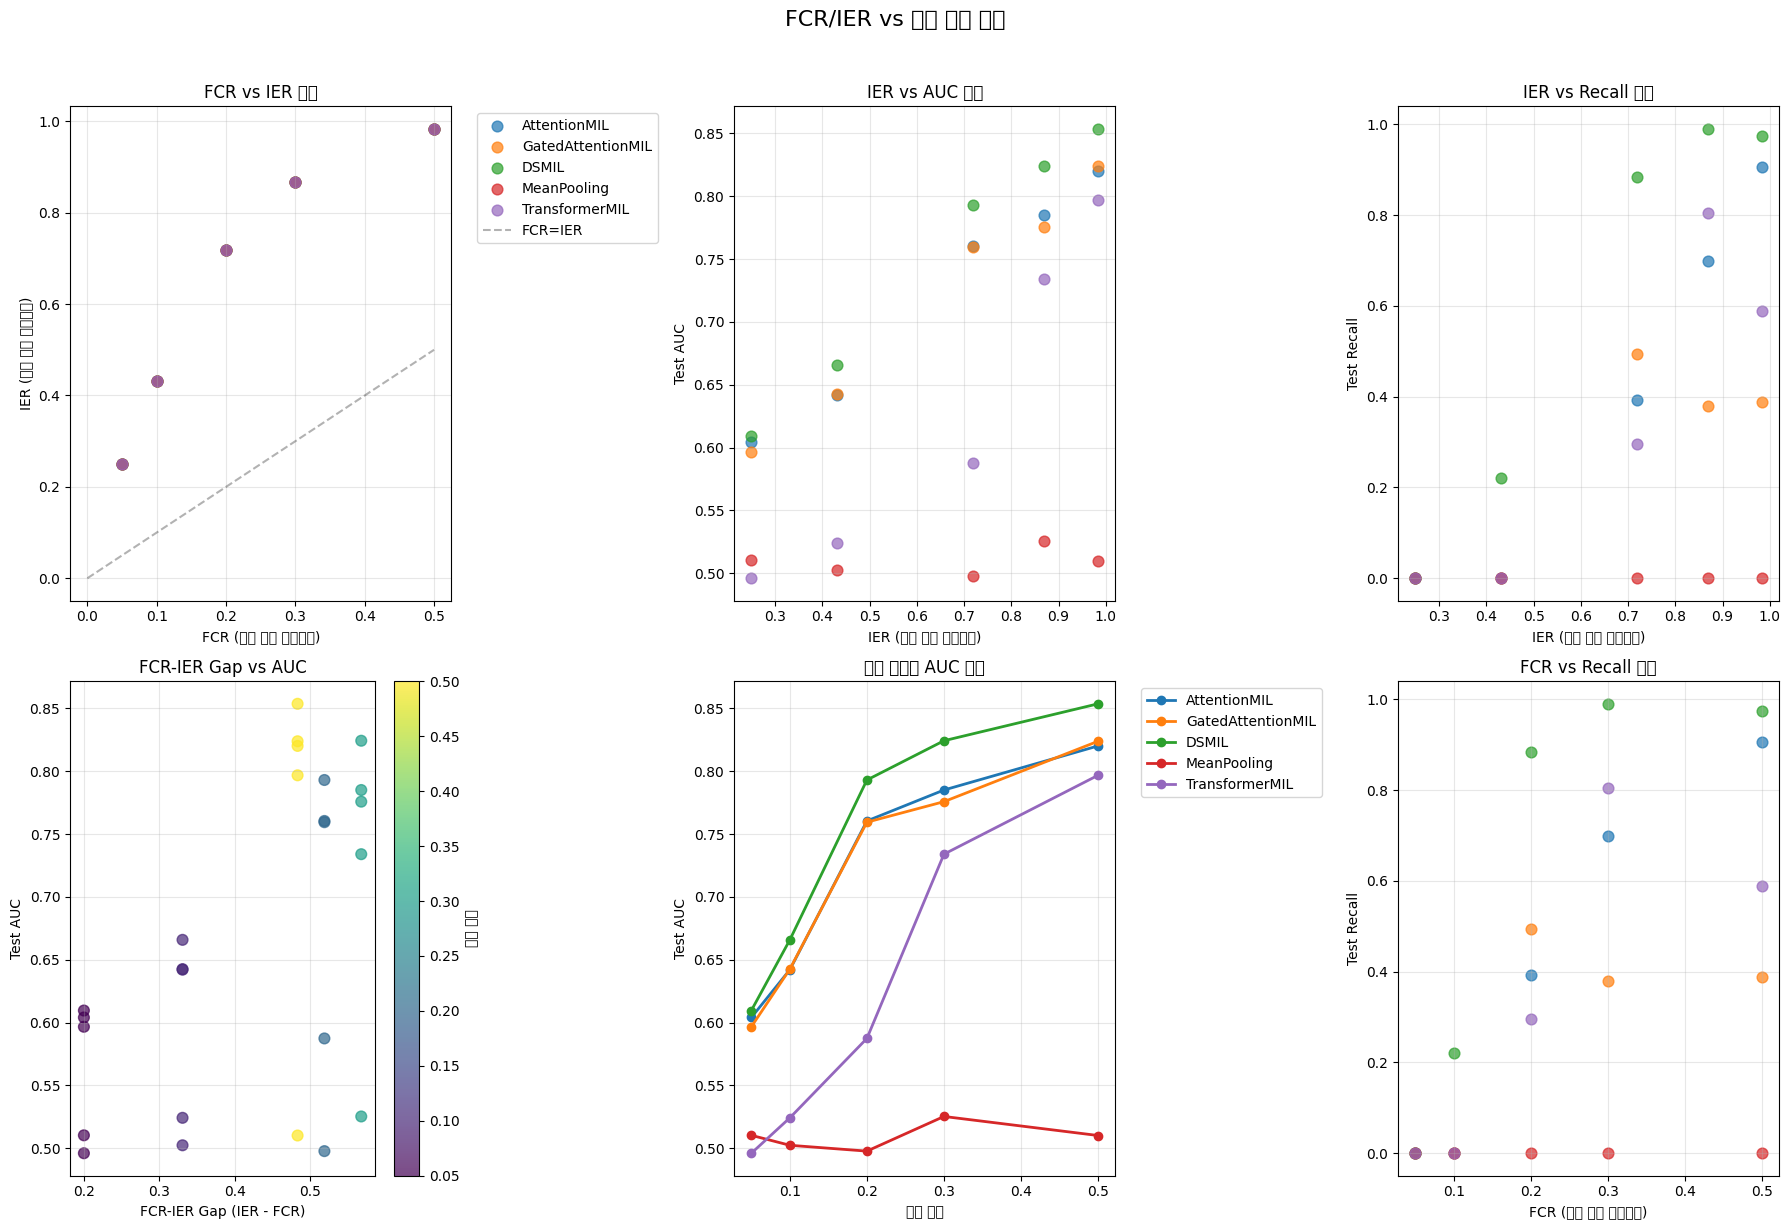


🔥 FCR/IER vs Performance Correlation Heatmap:


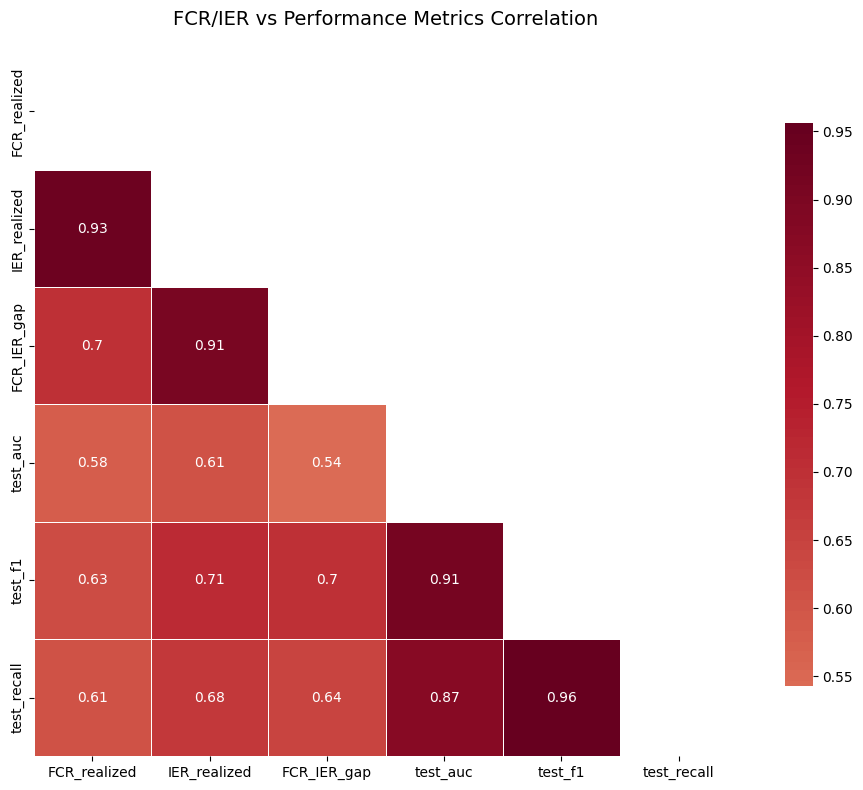


⚖️ Model FCR-IER Gap Utilization Efficiency:


,avg_gap,avg_auc,gap_efficiency,low_ratio_performance
model,,,,
DSMIL,0.42,0.749,1.741,0.638
AttentionMIL,0.42,0.722,1.679,0.623
GatedAttentionMIL,0.42,0.720,1.673,0.620
TransformerMIL,0.42,0.628,1.459,0.510
MeanPooling,0.42,0.509,1.183,0.506



💼 Practical Application Recommendations:

🎯 Optimal model for 5% forgery ratio:
  • Model: DSMIL
  • AUC: 0.610
  • Recall: 0.000
  • FCR: 0.050 → IER: 0.249
  • Model perceived ratio: 5.0x

🎯 Optimal model for 10% forgery ratio:
  • Model: DSMIL
  • AUC: 0.666
  • Recall: 0.220
  • FCR: 0.100 → IER: 0.431
  • Model perceived ratio: 4.3x

🎯 Optimal model for 20% forgery ratio:
  • Model: DSMIL
  • AUC: 0.793
  • Recall: 0.883
  • FCR: 0.200 → IER: 0.719
  • Model perceived ratio: 3.6x

🎯 Optimal model for 30% forgery ratio:
  • Model: DSMIL
  • AUC: 0.824
  • Recall: 0.990
  • FCR: 0.300 → IER: 0.868
  • Model perceived ratio: 2.9x

🎯 Optimal model for 50% forgery ratio:
  • Model: DSMIL
  • AUC: 0.854
  • Recall: 0.975
  • FCR: 0.500 → IER: 0.984
  • Model perceived ratio: 2.0x

🏆 Research Contributions and Key Findings:
✅ Average IER/FCR ratio: 3.6x
   → Models experience 3.6x more forgery instances than actual ratio

✅ Low-ratio forgery detection performance:
   → DSMIL achieved 0.

In [14]:
# FCR/IER vs Performance Visualization and Analysis
if 'analysis_df' in globals() and len(analysis_df) > 0:
    print('📊 FCR/IER vs Model Performance Visualization')
    print('=' * 60)
    
    # 1. Main visualization
    fig = plot_fcr_ier_analysis(analysis_df, figsize=(18, 12))
    plt.show()
    
    # 2. Correlation heatmap
    print('\n🔥 FCR/IER vs Performance Correlation Heatmap:')
    corr_vars = ['FCR_realized', 'IER_realized', 'FCR_IER_gap', 'test_auc', 'test_f1', 'test_recall']
    corr_data = analysis_df[corr_vars].dropna()
    
    # Set font for heatmap
    plt.rcParams['font.family'] = 'DejaVu Sans'
    
    plt.figure(figsize=(10, 8))
    mask = np.triu(np.ones_like(corr_data.corr(), dtype=bool))
    sns.heatmap(corr_data.corr(), mask=mask, annot=True, cmap='RdBu_r', center=0,
                square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
    plt.title('FCR/IER vs Performance Metrics Correlation', fontsize=14, pad=20)
    plt.tight_layout()
    plt.show()
    
    # 3. FCR-IER Gap efficiency analysis
    print('\n⚖️ Model FCR-IER Gap Utilization Efficiency:')
    efficiency_analysis = analysis_df.groupby('model').apply(
        lambda x: pd.Series({
            'avg_gap': x['FCR_IER_gap'].mean(),
            'avg_auc': x['test_auc'].mean(),
            'gap_efficiency': x['test_auc'].mean() / (x['FCR_IER_gap'].mean() + 0.01),  # Prevent division by zero
            'low_ratio_performance': x[x['ratio'] <= 0.10]['test_auc'].mean()
        })
    ).round(3).sort_values('gap_efficiency', ascending=False)
    
    display(efficiency_analysis)
    
    # 4. Practical recommendations
    print('\n💼 Practical Application Recommendations:')
    print('=' * 50)
    
    # Optimal model for each forgery ratio
    for ratio in [0.05, 0.10, 0.20, 0.30, 0.50]:
        ratio_data = analysis_df[analysis_df['ratio'] == ratio].sort_values('test_auc', ascending=False)
        if len(ratio_data) > 0:
            best_model = ratio_data.iloc[0]
            print(f"\n🎯 Optimal model for {ratio:.0%} forgery ratio:")
            print(f"  • Model: {best_model['model']}")
            print(f"  • AUC: {best_model['test_auc']:.3f}")
            print(f"  • Recall: {best_model['test_recall']:.3f}")
            print(f"  • FCR: {best_model['FCR_realized']:.3f} → IER: {best_model['IER_realized']:.3f}")
            print(f"  • Model perceived ratio: {best_model['IER_realized']/best_model['FCR_realized']:.1f}x")
    
    # 5. Research contributions summary
    print('\n🏆 Research Contributions and Key Findings:')
    print('=' * 50)
    
    avg_ier_fcr_ratio = (analysis_df['IER_realized'] / analysis_df['FCR_realized']).mean()
    best_low_ratio_model = analysis_df[analysis_df['ratio'] <= 0.10].sort_values('test_auc', ascending=False)
    
    print(f"✅ Average IER/FCR ratio: {avg_ier_fcr_ratio:.1f}x")
    print(f"   → Models experience {avg_ier_fcr_ratio:.1f}x more forgery instances than actual ratio")
    
    if len(best_low_ratio_model) > 0:
        best_low = best_low_ratio_model.iloc[0]
        print(f"\n✅ Low-ratio forgery detection performance:")
        print(f"   → {best_low['model']} achieved {best_low['test_auc']:.3f} AUC at {best_low['ratio']:.0%} forgery")
        if best_low['test_auc'] >= 0.8:
            print(f"   → Practical performance threshold achieved 🎉")
        
    high_performers = analysis_df[analysis_df['test_auc'] >= 0.85]
    if len(high_performers) > 0:
        print(f"\n✅ High-performance achievements:")
        print(f"   → {len(high_performers)} model-ratio combinations achieved AUC ≥ 0.85")
        best_overall = high_performers.sort_values('test_auc', ascending=False).iloc[0]
        print(f"   → Best performance: {best_overall['model']} @ {best_overall['ratio']:.0%} (AUC: {best_overall['test_auc']:.3f})")
    
    # 6. Limitations and future directions
    print('\n📋 Research Limitations and Future Directions:')
    print('=' * 50)
    
    low_recall_cases = analysis_df[analysis_df['test_recall'] < 0.5]
    if len(low_recall_cases) > 0:
        print(f"⚠️  Low Recall (<0.5) cases: {len(low_recall_cases)} instances")
        print("   → Risk of missing forgeries, recall improvement needed")
    
    model_variance = analysis_df.groupby('model')['test_auc'].std()
    high_variance_models = model_variance[model_variance > 0.1]
    if len(high_variance_models) > 0:
        print(f"\n⚠️  High performance variance models: {list(high_variance_models.index)}")
        print("   → Performance instability across forgery ratios")
    
    print(f"\n🔬 Future research directions:")
    print("   • Develop IER-based adaptive learning strategies")
    print("   • Optimize model architectures using FCR-IER Gap")
    print("   • Validate performance in real document environments")
    
else:
    print('ℹ️ No analysis data available. Please run previous cells first.')

print('\n' + '=' * 80)
print('🎯 Comprehensive FCR/IER Analysis Complete!')
print('=' * 80)